In [1]:
import numpy as np
import bms_env
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random


from utils import *



# Import the necessary libraries
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env

In [2]:
# bms = bms_env.BMSenv(num_cells= 2, k_tanh_params= [0.75, 1.5], Q_cells = [2.35, 2.35])
bms = bms_env.BMSenv(num_cells= 5, k_tanh_params= [0.8, 2.5, 0.5, 1.5, 2], Q_cells = [2.35, 1., 0.5, 3, 1.75])
num_cells_ = 100

np.random.seed(0)
bms = bms_env.BMSenv(num_cells= num_cells_,
                     k_tanh_params= np.random.uniform(1, 2, num_cells_),
                     Q_cells = np.random.uniform(2, 4, num_cells_))

T = 30_000
print(bms)

BMSenv(num_cells=100,
        k_tanh_params=[1.5488135  1.71518937 1.60276338 1.54488318 1.4236548  1.64589411
 1.43758721 1.891773   1.96366276 1.38344152 1.79172504 1.52889492
 1.56804456 1.92559664 1.07103606 1.0871293  1.0202184  1.83261985
 1.77815675 1.87001215 1.97861834 1.79915856 1.46147936 1.78052918
 1.11827443 1.63992102 1.14335329 1.94466892 1.52184832 1.41466194
 1.26455561 1.77423369 1.45615033 1.56843395 1.0187898  1.6176355
 1.61209572 1.616934   1.94374808 1.6818203  1.3595079  1.43703195
 1.6976312  1.06022547 1.66676672 1.67063787 1.21038256 1.1289263
 1.31542835 1.36371077 1.57019677 1.43860151 1.98837384 1.10204481
 1.20887676 1.16130952 1.65310833 1.2532916  1.46631077 1.24442559
 1.15896958 1.11037514 1.65632959 1.13818295 1.19658236 1.36872517
 1.82099323 1.09710128 1.83794491 1.09609841 1.97645947 1.4686512
 1.97676109 1.60484552 1.73926358 1.03918779 1.28280696 1.12019656
 1.2961402  1.11872772 1.31798318 1.41426299 1.0641475  1.69247212
 1.56660145 1.2653894

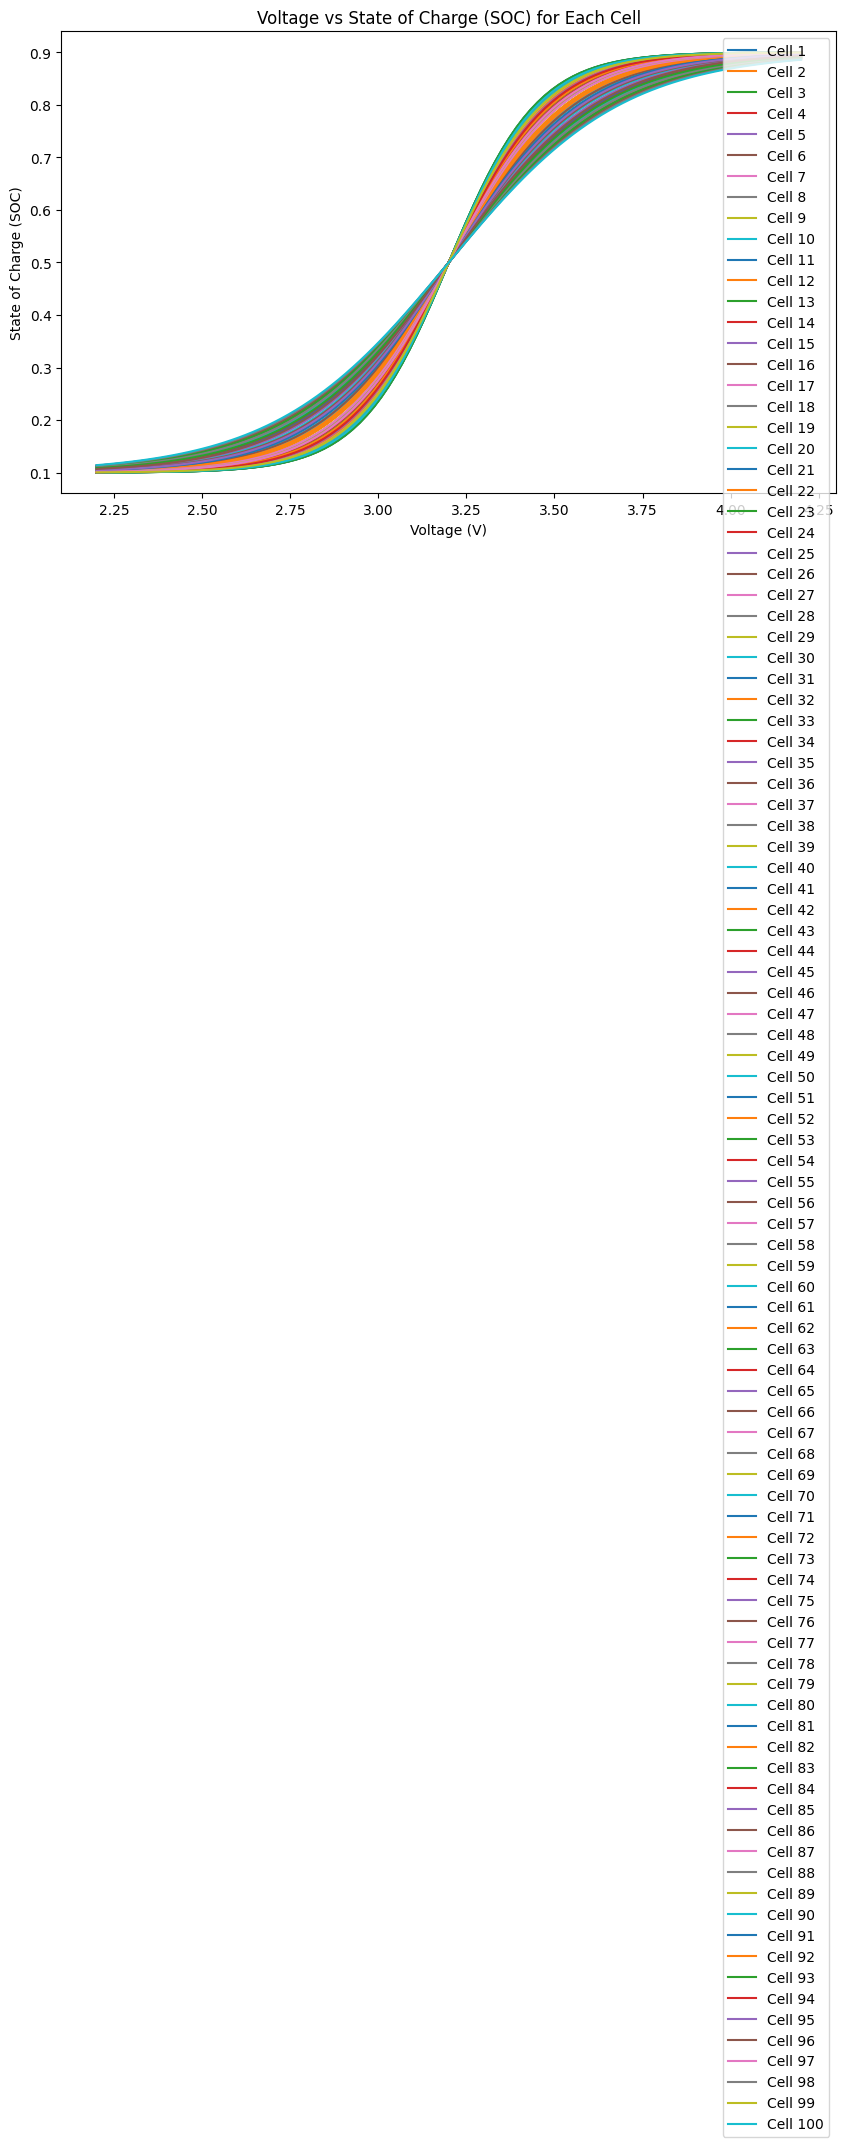

In [3]:
plot_voltage_vs_soc(bms)

# Random Controller

In [4]:
bms.reset()
states_5 = [bms.state]
states_soc_5 = [bms.state_soc]
actions_5 = []
rewards_5 = []
dones_5 = [False]
actions_int_5 = []

while not dones_5[-1] and len(states_5) < T:
    action = bms.action_space.sample()
    # while action == 0:
    #     action = bms.action_space.sample()
    actions_int_5.append(bms.switch_action_to_int_action(action))
    state, reward, done, _, _ = bms.step(action)
    states_5.append(state)
    states_soc_5.append(bms.state_soc)
    actions_5.append(action)
    rewards_5.append(reward)
    dones_5.append(done)

print(f"Sum of rewards: {np.sum(rewards_5)}")

Sum of rewards: -38.76468146218338


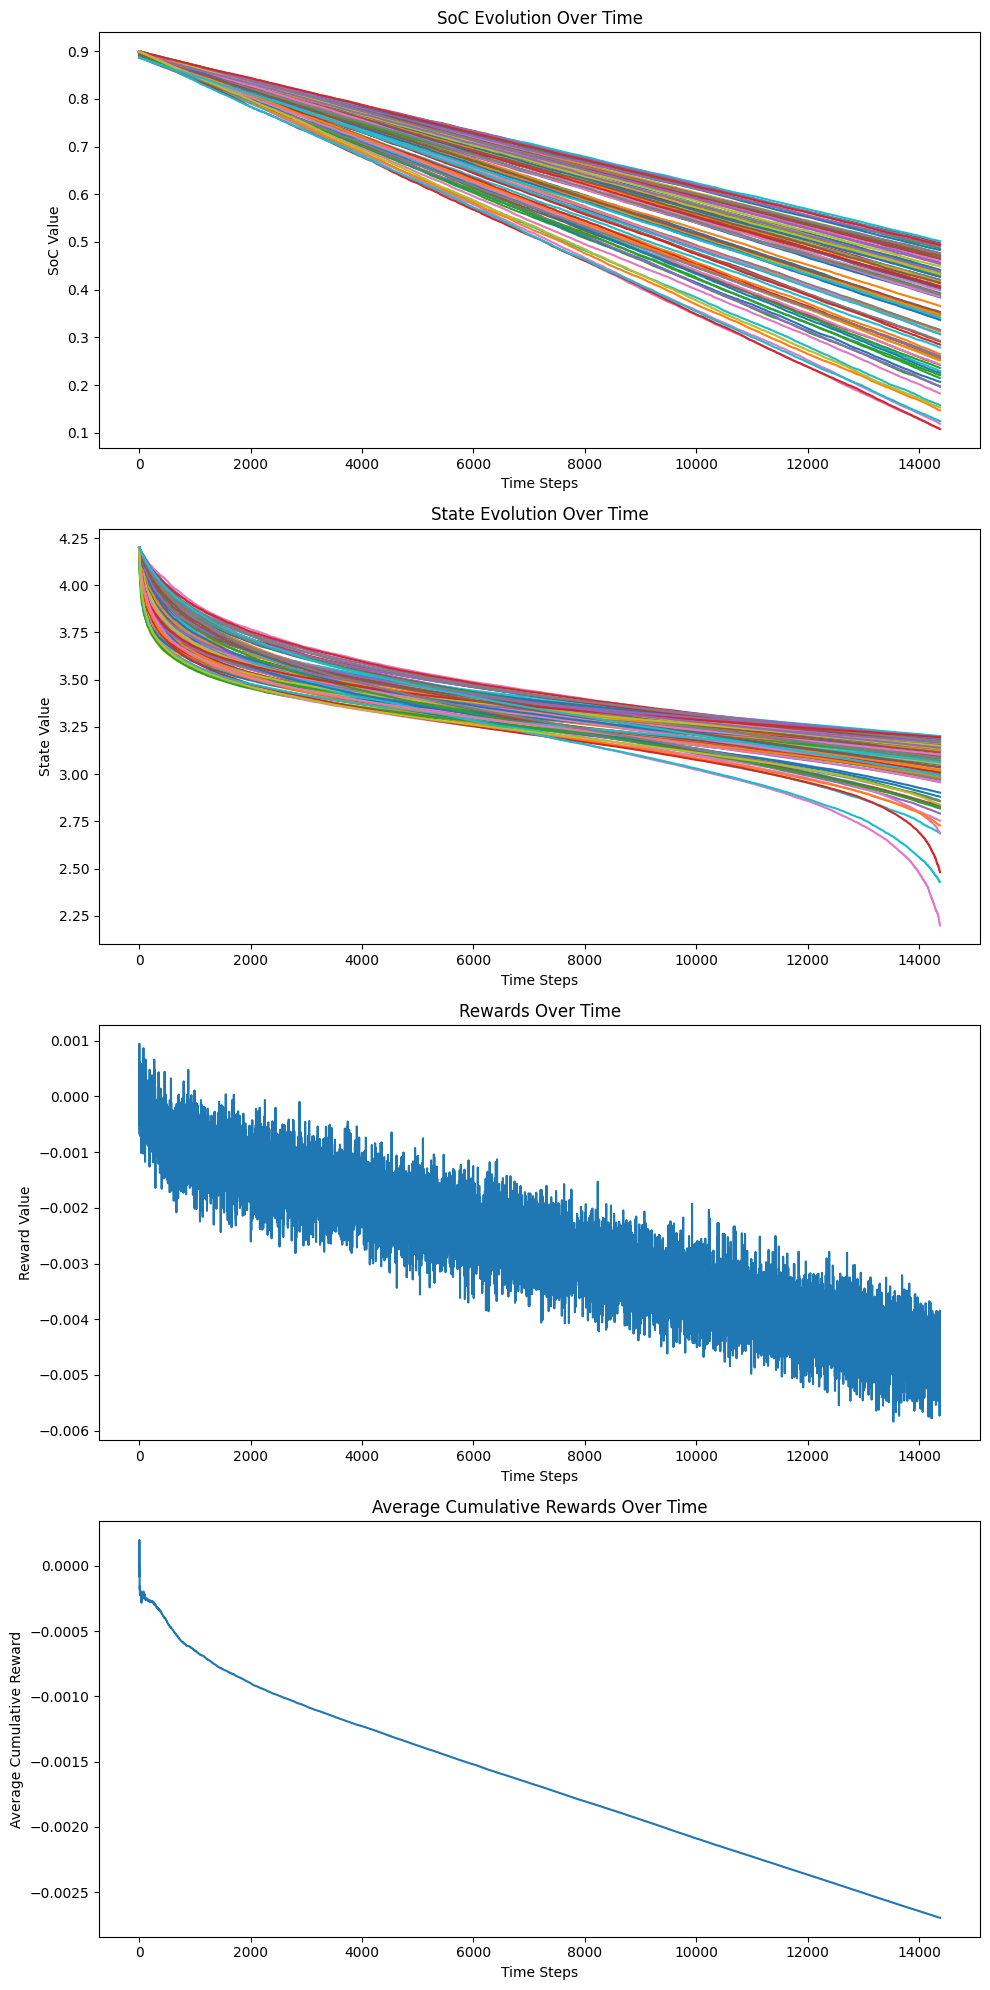

In [5]:
# Convert list of arrays to a 2D array for easier plotting
data_array_soc = np.array(states_soc_5)
data_array_states = np.array(states_5)
data_array_rewards = np.array(rewards_5)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot states_soc_5
for feature_idx in range(bms.num_cells):
    axs[0].plot(range(len(data_array_soc)), data_array_soc[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('SoC Value')
axs[0].set_title('SoC Evolution Over Time')
# axs[0].legend()

# Plot states_5
for feature_idx in range(bms.num_cells):
    axs[1].plot(range(len(data_array_states)), data_array_states[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('State Value')
axs[1].set_title('State Evolution Over Time')
# axs[1].legend()

# Plot rewards_5
axs[2].plot(range(len(data_array_rewards)), data_array_rewards, label='Rewards')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Reward Value')
axs[2].set_title('Rewards Over Time')
# axs[2].legend()

# Plot average cumulative rewards
cumulative_rewards = np.cumsum(data_array_rewards)
average_cumulative_rewards = cumulative_rewards / (np.arange(len(cumulative_rewards)) + 1)
axs[3].plot(range(len(average_cumulative_rewards)), average_cumulative_rewards, label='Average Cumulative Rewards')
axs[3].set_xlabel('Time Steps')
axs[3].set_ylabel('Average Cumulative Reward')
axs[3].set_title('Average Cumulative Rewards Over Time')
# axs[3].legend()

plt.tight_layout()
plt.show()

# TABULAR Q-Learning

In [12]:
# bins = np.array([2.2, 2.5, 2.8, 3, 3.15, 3.30 , 3.40, 3.50 , 3.65, 3.80, 4.0 ,4.2])
bins = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])



In [13]:
bins

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [14]:
print(bms.int_action_to_switch_action(0))
print(bms.int_action_to_switch_action(1))
print(bms.int_action_to_switch_action(2))
print(bms.int_action_to_switch_action(3))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]


# Efficient Tabular Q-Learning

In [88]:
# Initialize the Q-table with a default value of 0.0 for each (state, action) pair
init_Q_value = 0.0
Q_1 = defaultdict(lambda: init_Q_value)
bms.MAX_VOLTAGE = 4.2
bms.MIN_VOLTAGE = 3.6
Q = Q_1


In [89]:
# Assuming bms, bins, T, and other relevant variables/functions are already defined

num_episodes = 11

memory_threshold = 1e-4

for episode in range(num_episodes):

    bms.reset()
    states_6 = [bms.state]
    states_soc_6 = [bms.state_soc]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 1/(episode + 1)
    stepsize = 0.5
    gamma = 0.99

    if episode  >= num_episodes - 2:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:

        if len(dones_6) % 1000 == 0:
            print('\n')
            print(f"Episode: {episode + 1}")
            print(f"Timesteps: {len(dones_6)}")
            print(len(Q))

        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

            if state_actions:
                max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
                max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
                action_int = random.choice(max_actions)
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
            else:
                action = bms.action_space.sample()

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = bms.state_soc
        states_6.append(state)
        states_soc_6.append(state_soc)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
            if next_state_actions:
                max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
            else:
                max_next_q_value = 0.0

            if (state_int, action_int) not in Q:
                Q[(state_int, action_int)] = init_Q_value

            Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
                reward + gamma * max_next_q_value - Q[(state_int, action_int)]
            )

        # # Remove entries with Q-values less than 0.0
        Q = {k: v for k, v in Q.items() if v >= memory_threshold}
        if len(Q) > 1_000:
            memory_threshold*=1.1
        if len(Q) < 500:
            memory_threshold/=1.1



    if episode % 2 == 0:
        print('\n\n')
        print(f"Episode: {episode + 1}")
        print(f"Sum of rewards: {np.sum(rewards_6)}")
        print(f"Timesteps: {len(dones_6)}")
        print(f"Number of states visited: {len(set(states_int_6))}")
        print(f"Number of random actions: {sum(random_actions_6)}")
        print(f"Number of unique (state, action) pairs: {len(Q)}")

Q_1 = Q




Episode: 1
Sum of rewards: -0.34348345071156194
Timesteps: 656
Number of states visited: 1
Number of random actions: 655
Number of unique (state, action) pairs: 408



Episode: 3
Sum of rewards: -0.19669771473387576
Timesteps: 654
Number of states visited: 1
Number of random actions: 231
Number of unique (state, action) pairs: 944



Episode: 5
Sum of rewards: -0.17117982442906826
Timesteps: 714
Number of states visited: 1
Number of random actions: 157
Number of unique (state, action) pairs: 993



Episode: 7
Sum of rewards: -0.18101870677179518
Timesteps: 609
Number of states visited: 1
Number of random actions: 101
Number of unique (state, action) pairs: 965



Episode: 9
Sum of rewards: -0.11868991006976504
Timesteps: 653
Number of states visited: 1
Number of random actions: 72
Number of unique (state, action) pairs: 987



Episode: 11
Sum of rewards: -0.0982428594255037
Timesteps: 667
Number of states visited: 1
Number of random actions: 0
Number of unique (state, action) pairs:

In [86]:
# Initialize the Q-table with a default value of 0.0 for each (state, action) pair
init_Q_value = 0.0
Q_2 = defaultdict(lambda: init_Q_value)
bms.MAX_VOLTAGE = 3.7
bms.MIN_VOLTAGE = 3.4
Q = Q_2


In [87]:
# Assuming bms, bins, T, and other relevant variables/functions are already defined

num_episodes = 51

memory_threshold = 1e-4

for episode in range(num_episodes):

    bms.reset()
    states_6 = [bms.state]
    states_soc_6 = [bms.state_soc]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 1/(episode + 1)
    stepsize = 0.5
    gamma = 0.99

    if episode  >= num_episodes - 2:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:


        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

            if state_actions:
                max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
                max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
                action_int = random.choice(max_actions)
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
            else:
                action = bms.action_space.sample()

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = bms.state_soc
        states_6.append(state)
        states_soc_6.append(state_soc)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
            if next_state_actions:
                max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
            else:
                max_next_q_value = 0.0

            if (state_int, action_int) not in Q:
                Q[(state_int, action_int)] = init_Q_value

            Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
                reward + gamma * max_next_q_value - Q[(state_int, action_int)]
            )

        # # Remove entries with Q-values less than 0.0
        Q = {k: v for k, v in Q.items() if v >= memory_threshold}
        if len(Q) > 1_000:
            memory_threshold*=1.01
        if len(Q) < 500:
            memory_threshold/=1.1



    if episode % 2 == 0:
        print('\n\n')
        print(f"Episode: {episode + 1}")
        print(f"Sum of rewards: {np.sum(rewards_6)}")
        print(f"Timesteps: {len(dones_6)}")
        print(f"Number of states visited: {len(set(states_int_6))}")
        print(f"Number of random actions: {sum(random_actions_6)}")
        print(f"Number of unique (state, action) pairs: {len(Q)}")


Q_2 = Q




Episode: 1
Sum of rewards: -2.839110944250313
Timesteps: 2404
Number of states visited: 95
Number of random actions: 2403
Number of unique (state, action) pairs: 9



Episode: 3
Sum of rewards: -2.2217912182282724
Timesteps: 2241
Number of states visited: 83
Number of random actions: 742
Number of unique (state, action) pairs: 199



Episode: 5
Sum of rewards: -2.570933774292273
Timesteps: 2374
Number of states visited: 93
Number of random actions: 480
Number of unique (state, action) pairs: 273



Episode: 7
Sum of rewards: -2.2068589241559264
Timesteps: 2161
Number of states visited: 84
Number of random actions: 283
Number of unique (state, action) pairs: 351



Episode: 9
Sum of rewards: -2.3481063260010018
Timesteps: 2366
Number of states visited: 89
Number of random actions: 272
Number of unique (state, action) pairs: 406



Episode: 11
Sum of rewards: -2.1823501731494543
Timesteps: 2267
Number of states visited: 87
Number of random actions: 205
Number of unique (state, action)

In [75]:
# Initialize the Q-table with a default value of 0.0 for each (state, action) pair
init_Q_value = 0.0
Q_3 = defaultdict(lambda: init_Q_value)
bms.MAX_VOLTAGE = 3.5
bms.MIN_VOLTAGE = 3.2
Q = Q_3


In [76]:
# Assuming bms, bins, T, and other relevant variables/functions are already defined

num_episodes = 11

memory_threshold = -1e-5

for episode in range(num_episodes):

    bms.reset()
    states_6 = [bms.state]
    states_soc_6 = [bms.state_soc]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 1/(episode + 1)
    stepsize = 0.5
    gamma = 0.99

    if episode  >= num_episodes - 2:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:


        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

            if state_actions:
                max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
                max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
                action_int = random.choice(max_actions)
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
            else:
                action = bms.action_space.sample()

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = bms.state_soc
        states_6.append(state)
        states_soc_6.append(state_soc)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
            if next_state_actions:
                max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
            else:
                max_next_q_value = 0.0

            if (state_int, action_int) not in Q:
                Q[(state_int, action_int)] = init_Q_value

            Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
                reward + gamma * max_next_q_value - Q[(state_int, action_int)]
            )

        # # Remove entries with Q-values less than 0.0
        Q = {k: v for k, v in Q.items() if v >= memory_threshold}
        if len(Q) > 5_000:
            memory_threshold =  memory_threshold + np.abs((memory_threshold))/10
        if len(Q) < 500:
            memory_threshold = memory_threshold - np.abs((memory_threshold))/10



    if episode % 2 == 0:
        print('\n\n')
        print(f"Episode: {episode + 1}")
        print(f"Sum of rewards: {np.sum(rewards_6)}")
        print(f"Timesteps: {len(dones_6)}")
        print(f"Number of states visited: {len(set(states_int_6))}")
        print(f"Number of random actions: {sum(random_actions_6)}")
        print(f"Number of unique (state, action) pairs: {len(Q)}")
        print(f"Memory threshold: {memory_threshold}")

Q_3 = Q




Episode: 1
Sum of rewards: -7.725805426542239
Timesteps: 4409
Number of states visited: 166
Number of random actions: 4408
Number of unique (state, action) pairs: 983
Memory threshold: -0.000929271587798655



Episode: 3
Sum of rewards: -7.721080290355587
Timesteps: 4308
Number of states visited: 165
Number of random actions: 1414
Number of unique (state, action) pairs: 671
Memory threshold: -0.0006096950887546975



Episode: 5
Sum of rewards: -7.322677347467632
Timesteps: 4288
Number of states visited: 164
Number of random actions: 840
Number of unique (state, action) pairs: 836
Memory threshold: -0.0005487255798792278



Episode: 7
Sum of rewards: -7.399942041957541
Timesteps: 4304
Number of states visited: 164
Number of random actions: 644
Number of unique (state, action) pairs: 826
Memory threshold: -0.000493853021891305



Episode: 9
Sum of rewards: -7.484376364496805
Timesteps: 4325
Number of states visited: 167
Number of random actions: 494
Number of unique (state, action) pa

In [96]:
from collections import defaultdict

# Assuming Q1, Q2, and Q3 are your dictionaries
Q1 = defaultdict(lambda: 0.0, Q_1)
Q2 = defaultdict(lambda: 0.0, Q_2)
Q3 = defaultdict(lambda: 0.0, Q_3)

# Create a new dictionary to store the combined results
Q_combined = defaultdict(lambda: 0.0)
count = defaultdict(int)

# Function to update the combined dictionary
def update_combined(Q):
    for key, value in Q.items():
        Q_combined[key] += value
        count[key] += 1

# Update the combined dictionary with Q1, Q2, and Q3
update_combined(Q1)
update_combined(Q2)
update_combined(Q3)

# Average the values for keys that appear in multiple dictionaries
for key in Q_combined:
    Q_combined[key] /= count[key]

# Q_combined now contains the combined and averaged values

In [97]:
len(Q_combined)

2624

In [102]:
Q = Q_combined
len(Q)

2624

In [103]:
bms.MAX_VOLTAGE = 4.2
bms.MIN_VOLTAGE = 3.2

In [104]:
# Assuming bms, bins, T, and other relevant variables/functions are already defined

bms.reset()
states_6 = [bms.state]
states_soc_6 = [bms.state_soc]
actions_6 = []
rewards_6 = []
dones_6 = [False]
random_actions_6 = []
actions_int_6 = []
states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

epsilon = 0.0
stepsize = 0.5
gamma = 0.99



while not dones_6[-1] and len(states_soc_6) < T:


    if len(dones_6) % 100 == 0:
        print('\n')
        print(f"Timesteps: {len(dones_6)}")
        print(len(Q))


    state_int = tuple(discretize_features(states_soc_6[-1], bins))

    if np.random.uniform(0, 1) < epsilon:
        random_actions_6.append(True)
        action = bms.action_space.sample()
    else:
        random_actions_6.append(False)
        # Collect all actions with non-zero Q-values for the current state
        state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

        if state_actions:
            max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
            max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
            action_int = random.choice(max_actions)
            action = np.array(action_int)
            if max_q_value < init_Q_value:
                action = bms.action_space.sample()
        else:
            action = bms.action_space.sample()

    action_int = tuple(action)
    actions_int_6.append(action_int)

    state, reward, done, _, _ = bms.step(action)
    state_soc = bms.state_soc
    states_6.append(state)
    states_soc_6.append(state_soc)
    actions_6.append(action)
    rewards_6.append(reward)
    dones_6.append(done)

    if not done:
        next_state_int = tuple(discretize_features(state_soc, bins))
        states_int_6.append(next_state_int)
        next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
        if next_state_actions:
            max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
        else:
            max_next_q_value = 0.0

        if (state_int, action_int) not in Q:
            Q[(state_int, action_int)] = init_Q_value

        Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
            reward + gamma * max_next_q_value - Q[(state_int, action_int)]
        )

    






In [105]:
len(Q)

8089

/var/folders/0w/_5fcsdzs7bjgmvyjv25_b9l80000gp/T/ipykernel_96341/758027510.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


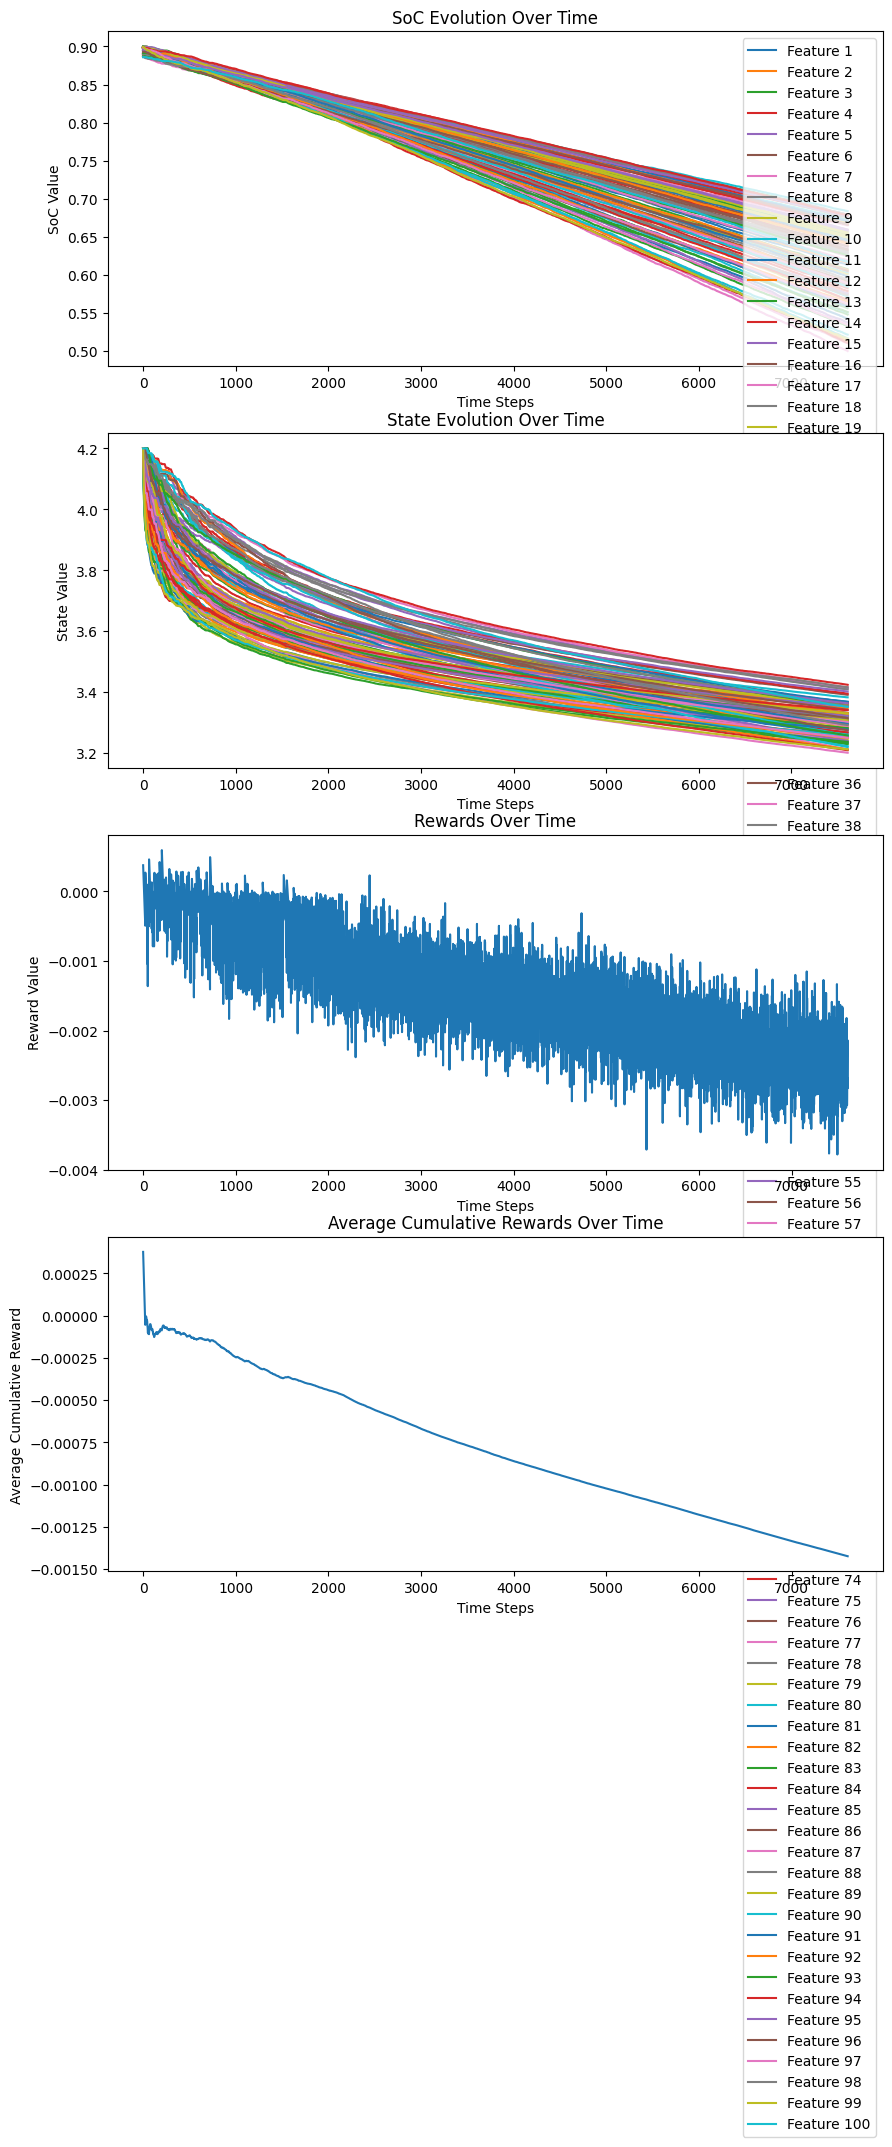

In [106]:
# Convert list of arrays to a 2D array for easier plotting
data_array_soc = np.array(states_soc_6)
data_array_states = np.array(states_6)
data_array_rewards = np.array(rewards_6)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot states_soc_5
for feature_idx in range(bms.num_cells):
    axs[0].plot(range(len(data_array_soc)), data_array_soc[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('SoC Value')
axs[0].set_title('SoC Evolution Over Time')
axs[0].legend()

# Plot states_5
for feature_idx in range(bms.num_cells):
    axs[1].plot(range(len(data_array_states)), data_array_states[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('State Value')
axs[1].set_title('State Evolution Over Time')
# axs[1].legend()

# Plot rewards_5
axs[2].plot(range(len(data_array_rewards)), data_array_rewards, label='Rewards')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Reward Value')
axs[2].set_title('Rewards Over Time')
# axs[2].legend()

# Plot average cumulative rewards
cumulative_rewards = np.cumsum(data_array_rewards)
average_cumulative_rewards = cumulative_rewards / (np.arange(len(cumulative_rewards)) + 1)
axs[3].plot(range(len(average_cumulative_rewards)), average_cumulative_rewards, label='Average Cumulative Rewards')
axs[3].set_xlabel('Time Steps')
axs[3].set_ylabel('Average Cumulative Reward')
axs[3].set_title('Average Cumulative Rewards Over Time')
# axs[3].legend()

plt.tight_layout()
plt.show()

# PPO

In [12]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [13]:
model = PPO("MlpPolicy", bms,  verbose=1, gamma= 0.95, batch_size= 32)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [35]:
from stable_baselines3.common.callbacks import BaseCallback

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_state_ranges = []
        self.current_episode_rewards = []
        self.current_episode_state_ranges = []

    def _on_step(self) -> bool:
        # Access the current state and reward
        current_state = self.training_env.get_attr('state_soc')[0]
        # reward = self.training_env.get_attr('reward')[0]
        
        # Calculate the state range for the current state
        state_range = np.max(current_state) - np.min(current_state)
        
        # Append the current reward and state range to the current episode lists
        # self.current_episode_rewards.append(reward)
        self.current_episode_state_ranges.append(state_range)
        
        return True

    def _on_rollout_end(self) -> None:
        # Calculate the average reward and state range for the current episode
        # avg_reward = np.mean(self.current_episode_rewards)
        max_state_range = np.max(self.current_episode_state_ranges)
        
        # Append the averages to the episode lists
        # self.episode_rewards.append(avg_reward)
        self.episode_state_ranges.append(max_state_range)
        
        # Optionally, print or log the averages
        if self.verbose > 0:
            print(f"Episode Max State Range: {max_state_range}")
        
        # Reset the current episode lists
        self.current_episode_rewards = []
        self.current_episode_state_ranges = []

# Create the callback
custom_callback = CustomCallback(verbose=1)


In [12]:
model.save("ppo_bms")


In [14]:
model = PPO.load("ppo_bms", env=bms)
model.learn(total_timesteps= 2_500_000, callback=None)
model.save("ppo_bms")



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1294 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 573        |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.34846967 |
|    clip_fraction        | 0.797      |
|    clip_range           | 0.2        |
|    entropy_loss         | -188       |
|    explained_variance   | 0          |
|    learning_rate        | 0.001      |
|    loss                 | 0.0404     |
|    n_updates            | 21440      |
|    policy_gradient_loss | 0.0604     |
|    value_loss           | 0.101      |
----------------

In [13]:
model = PPO.load("ppo_bms")

bms.reset()
states_7 = [bms.state]
states_soc_7 = [bms.state_soc]
actions_7 = []
rewards_7 = []
dones_7 = [False]
random_actions_7 = []
actions_int_7 = []
states_int_7 = [tuple(discretize_features(states_soc_7[-1], bins))]

while not dones_7[-1] and len(states_7) <  T:
    action, _ = model.predict(bms.state, deterministic=False)
    actions_7.append(action)
    state_7, reward_7, done_7, _ , _= bms.step(action)
    states_7.append(state_7)
    states_soc_7.append(bms.state_soc)
    actions_int_7.append(tuple(action))
    rewards_7.append(reward_7)
    dones_7.append(done_7)

print(f"Sum of rewards: {np.sum(rewards_7)}")


Sum of rewards: -80.07837737140518


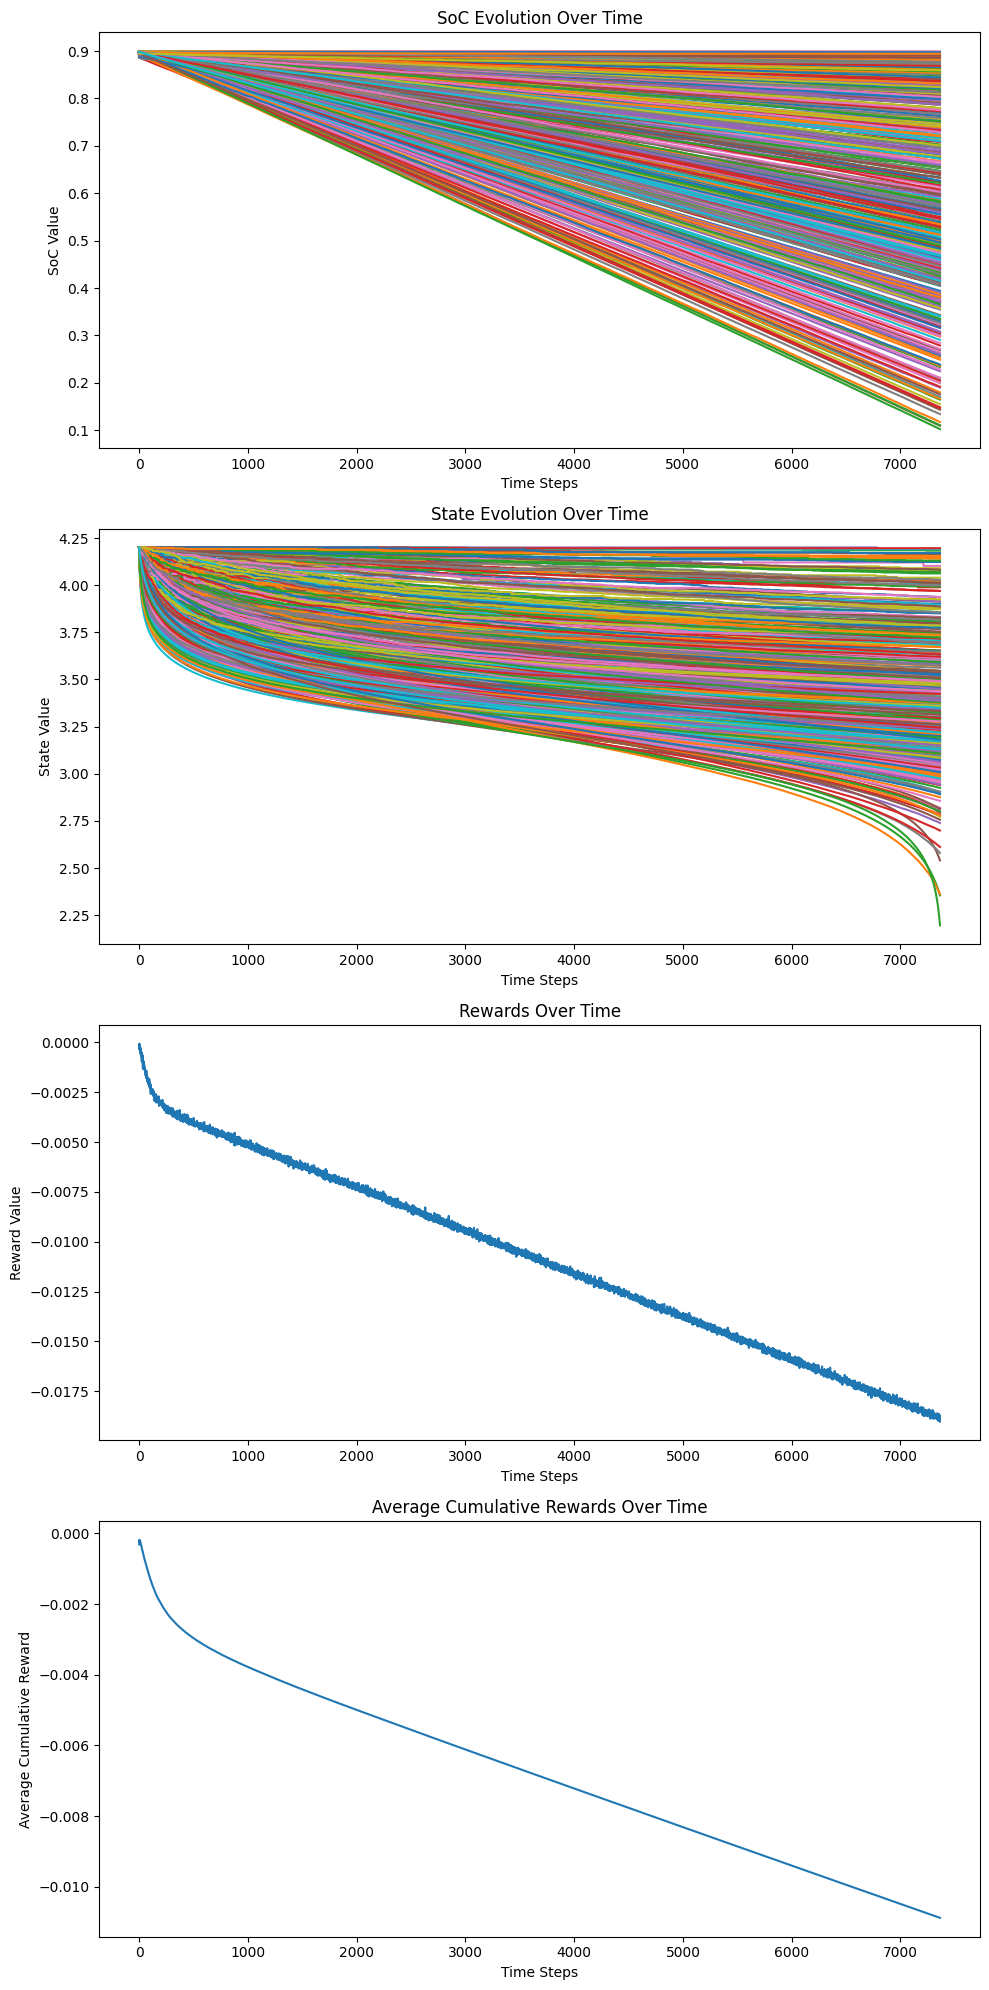

In [14]:
# Convert list of arrays to a 2D array for easier plotting
data_array_soc = np.array(states_soc_7)
data_array_states = np.array(states_7)
data_array_rewards = np.array(rewards_7)

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot states_soc_5
for feature_idx in range(bms.num_cells):
    axs[0].plot(range(len(data_array_soc)), data_array_soc[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('SoC Value')
axs[0].set_title('SoC Evolution Over Time')
# axs[0].legend()

# Plot states_5
for feature_idx in range(bms.num_cells):
    axs[1].plot(range(len(data_array_states)), data_array_states[:, feature_idx], label=f'Feature {feature_idx + 1}')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('State Value')
axs[1].set_title('State Evolution Over Time')
# axs[1].legend()

# Plot rewards_5
axs[2].plot(range(len(data_array_rewards)), data_array_rewards, label='Rewards')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Reward Value')
axs[2].set_title('Rewards Over Time')
# axs[2].legend()

# Plot average cumulative rewards
cumulative_rewards = np.cumsum(data_array_rewards)
average_cumulative_rewards = cumulative_rewards / (np.arange(len(cumulative_rewards)) + 1)
axs[3].plot(range(len(average_cumulative_rewards)), average_cumulative_rewards, label='Average Cumulative Rewards')
axs[3].set_xlabel('Time Steps')
axs[3].set_ylabel('Average Cumulative Reward')
axs[3].set_title('Average Cumulative Rewards Over Time')
# axs[3].legend()

plt.tight_layout()
plt.show()

In [ ]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

def objective(trial):
    # Define the hyperparameters to tune
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
    n_steps = trial.suggest_int('n_steps', 16, 2048)
    gamma = trial.suggest_uniform('gamma', 0.5, 0.9999)

    # Create the environment
    bms.reset()

    # Create the model with the suggested hyperparameters
    model = PPO("MlpPolicy", bms, verbose=0, ent_coef=ent_coef, learning_rate=learning_rate, n_steps=n_steps, gamma=gamma)

    # Train the model
    model.learn(total_timesteps=10000)

    # Evaluate the model
    rewards = []
    for _ in range(10):
        bms.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(bms.state, deterministic=True)
            _, reward, done, _, _ = bms.step(action)
            total_reward += reward
        rewards.append(total_reward)

    # Return the mean reward
    return np.mean(rewards)

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print(study.best_params)